In [103]:
import math as m
import numpy as np
from scipy import stats
from scipy import constants
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

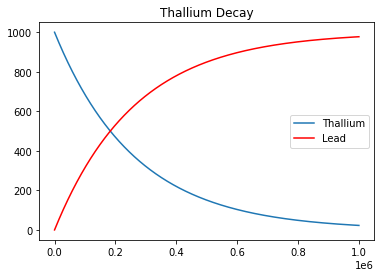

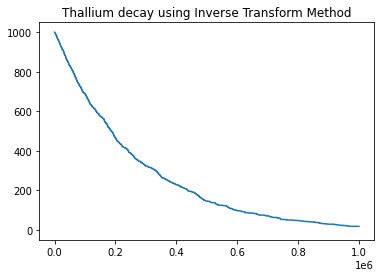

In [89]:
# ------------------------------- 1st approach
N = 1000000       #number of steps
thallium = np.zeros(N)
difference = 0
lead = np.zeros(N)
thallium[0] = 1000
tau = 3052*60
time = np.arange(N)

def p(t,tau):
    return 1-2**(-t/tau)

for t in range(1,N):
    difference = thallium[0]*p(t,tau)
    lead[t] = lead[0] + difference
    thallium[t] = thallium[0] - difference

plt.plot(time,thallium)
plt.plot(time,lead,'r')
plt.legend(['Thallium','Lead'])
plt.title('Thallium Decay')
ylim = plt.ylim()
plt.show()

# ------------------------------- 2nd approach
def icdf(z,tau):
    return -tau*m.log(1-z,2)
itm_time = np.array(list(map(lambda x: int(icdf(x,tau)), np.random.random(1000))))
itm_time = np.sort(itm_time)
# print(itm_time)
plot_time = np.arange(0,itm_time.max()+1)
thallium_array = np.full(plot_time.shape,1000)
thallium_array[0:itm_time[0]] = 1000
thallium_array[itm_time[0]:itm_time[1]] = 999
i = 1
while i < itm_time.shape[0]:
    j = i + 1
    while (j<itm_time.shape[0]) and (itm_time[i] == itm_time[j]): j+=1   # check if the next decay time is the same
    decrement = j - i                                                    # decrement: the number of atoms decayed in that time instant
    if j != itm_time.shape[0]:
        i = j
        thallium_array[itm_time[i-1]:itm_time[i]] = thallium_array[itm_time[i-decrement-1]] - decrement
    else:
        thallium_array[itm_time[i]:] = thallium_array[itm_time[i-1]] - decrement
        i = j
                           
plt.plot(plot_time[0:N],thallium_array[0:N])
# plt.plot(plot_time,thallium_array)
plt.ylim(ylim)
plt.title("Thallium decay using Inverse Transform Method")
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Compute the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [105]:
eps0 = constants.epsilon_0
pi = m.pi
def gold_scat(b):
    Z = 79
    e = m.e
    E = 7.7e6
    scat_tg = Z*e**2/(2*pi*eps0*E*b)
    return scat_tg
def particles_radius(z):
    a_0 = constants.physical_constants['Bohr radius']
    sigma = a_0[0] / 100
    r = np.sqrt(-2*sigma**2*np.log(1-z))
    return r

N = 1000000

particles_rad = np.array(list(map(particles_radius,np.random.random(N))))
particles_theta = 2*pi*np.random.random(N)
particles_x = particles_rad*np.cos(particles_theta)
particles_y = particles_rad*np.sin(particles_theta)

C:\Users\Giacomo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


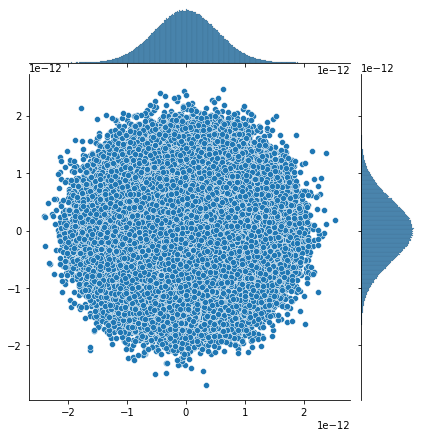

In [113]:
sns.jointplot(particles_x,particles_y, kind='scatter');

In [112]:
scat = np.array(list(map(gold_scat,particles_rad)))
print(scat)
print(scat[scat>1].shape)
print(7.7e6)

[2.07248750e+18 8.74767289e+17 3.23168105e+18 ... 2.01171411e+18
 1.41924193e+18 1.78697057e+18]
(1000000,)
7700000.0


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

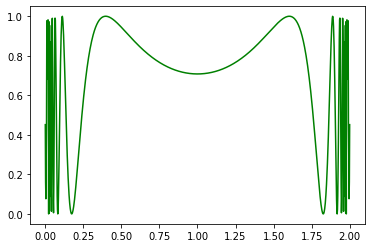

Value of the integral of the function between 0 and 2: 1.4536232774304347
Value of the integral calculated through the Montecarlo method: 1.45226
Estimation error: 0.0013632774304346285

Value of the integral calculated through the Mean Value Method: 1.4520730215840592
Estimation error: 0.0015502558463755811


In [138]:
# -------------------------------------- 1st approach
def f(x):
    return (np.sin(1/(x*(2-x))))**2

x = np.linspace(0.001,1.999,1000)
plt.plot(x,f(x),'g-')
plt.show()
true_I = np.trapz(f(x),x)
print("Value of the integral of the function between 0 and 2:", true_I)
N=100000
A = 2                     #A = 2 because we considere a rectangle of base 2 and height 1
count=0
for i in range(N):
    x=2*np.random.random()
    y=np.random.random()
    if y<f(x): count+=1
I=A*count/N               
print("Value of the integral calculated through the Montecarlo method:", I)
print("Estimation error:", true_I-I)

# -------------------------------------- 2nd approach
mvm_I = 2 * sum(np.array(list(map(f,np.random.random(N)))))/N                      # mvm = mean value method
print("\nValue of the integral calculated through the Mean Value Method:", mvm_I)
print("Estimation error:", true_I-mvm_I)


# Assuming the same number N the errors are similar. Therefore, both methods perform well

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [156]:
def f(x,y):
    if x**2+y**2<=1: return 1
    else: return 0
def multi_dim_f(x):
    if sum(map(lambda y: y**2,x))<=1: return 1
    else: return 0

N = 10000
A = 4 #Area of the square that contains the circle of radius 1
count_k = 0
for i in range(N):
    x = 2*np.random.random()-1
    y = 2*np.random.random()-1
    z = np.random.random()
    if z<f(x,y): count_k+=1

I = A*count_k/N
print("Area of a circle with unit radius:", I)

# Generalization
N_dim = 10
multi_A = 2**N_dim
count = 0
x = np.zeros(N_dim)
for i in range(N):
    for j in range(N_dim):
        x[j] = 2*np.random.random()-1
    z = np.random.random()
    if z<multi_dim_f(x): count+=1
        
multi_dim_I = multi_A*count/N
print("Integral of the sphere with",N_dim,"dimensions",multi_dim_I)

Area of a circle with unit radius: 3.1332
Integral of the sphere with 10 dimensions 2.3552


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [155]:
# value of the integral of w(x) between 0 and 1 is 2
def f(x):
    return 1/(np.sqrt(x)*(m.e**(x)+1))
def w(x):
    return 1/np.sqrt(x)

N = 100000
x = np.random.random(N)**2
f_x = np.array(list(map(f,x)))
w_x = np.array(list(map(w,x)))
is_sum = 0
for f_value,w_value in zip(f_x,w_x):
    is_sum += f_value/w_value                                         # is = importance sampling
I = 1/N * is_sum * 2
print("The value of the integral is", I)

The value of the integral is 0.8384442201911371
